# Goal & Setup

The purpose of this code is to apply diagnostics (e.g. from Bastos and O'Hagan 2009) to determine the quality of our LIG emulator, to see if it concurs with the ISM simulations. An adapation of their primary test is a Leave-One-Out analysis (LOO) to assess how well the **fit//trained** emulator reproduces the simulated runs.

In [1]:
# import the relevant packages
import numpy as np
import matplotlib.pyplot as plt
import pickle
import scipy

In [2]:
# define the colormap
plt.set_cmap('viridis')
# define the save path for our plots
fig_save_path='./figures/'
# import a series of colors for the prior vs. constraints plot
from lig_utilities import call_scm_cmap, uniform_cmap_slices
cmap=call_scm_cmap('roma')
cols=uniform_cmap_slices(cmap,6,col_range=[0,1.0])[::-1]
# define the BuRd colormap
cmap_RdBu = plt.cm.get_cmap('RdBu')
# import the rectangle feature
import matplotlib.patches as patches
# set the default grid style
plt.rcParams['grid.color'] = 'k'
plt.rcParams['grid.linestyle'] = ':'
plt.rcParams['grid.linewidth'] = 0.5

<Figure size 432x288 with 0 Axes>

In [3]:
# import the GPflow package to load the GP model and sample
import gpflow
from lig_utilities import normalize, denormalize
# load the modules to compute the statistics
from lig_utilities import posterior_densities_rcp85, find_quantile_i, find_quantile_ts
# import tensorflow so we can restore the trained model
import tensorflow as tf

# Data & Model

## Load the Emulator

### Load the Training Data (to reconstruct the GP model)

In [4]:
# load the training data from the pickle and print its keys
train_dat=pickle.load(open( "./models/lig_model_traindata.pk1", "rb" ) )
train_dat.keys()

dict_keys(['X_train', 'clifvmax', 'crevliq', 'Y_train', 'model_name', 'kernel_code'])

### Restore the Trained GP model

In [5]:
# reconstruct the GP model
with gpflow.defer_build():
    
    # define the kernel
    k = eval(train_dat['kernel_code'])

    # create the model
    m = gpflow.models.GPR(train_dat['X_train'], \
        train_dat['Y_train'].reshape(np.size(train_dat['Y_train']),1), kern=k, name=train_dat['model_name'])
    
    # Fix the nugget term
    #m.likelihood.variance = 1e-06
    #m.likelihood.trainable=False

# construct and compile the tensorflow session
tf.global_variables_initializer()
tf_graph = m.enquire_graph()
tf_session = m.enquire_session()
m.compile( tf_session )

# create the saver object and load the archived model object
saver = tf.train.Saver()
save_path = saver.restore(tf_session, "./models/lig_model.ckpt")
#save_path = saver.restore(tf_session, "./archived_models/lig_validateCV_Mat12xMat12y_2020-05-14_14:51:33.ckpt")
print("Model loaded from path: %s" % save_path)

# anchor the model to restore optimized hyperparameters
m.anchor(tf_session)

INFO:tensorflow:Restoring parameters from ./models/lig_model.ckpt


INFO:tensorflow:Restoring parameters from ./models/lig_model.ckpt


Model loaded from path: None


In [6]:
# print the hyperparameters
m.as_pandas_table()

,class,prior,transform,trainable,shape,fixed_shape,value
lig_model/kern/lengthscales,Parameter,None,+ve,True,(),True,45.69875317037066
lig_model/kern/variance,Parameter,None,+ve,True,(),True,17.048461576529924
lig_model/likelihood/variance,Parameter,None,+ve,True,(),True,1.0000000002220446e-06


### Get Baseline Samples

Here we sample the model at the training data points, for a baseline prediction.

In [7]:
# get model outputs along grid
baseline_mean,baseline_var=m.predict_y(train_dat['X_train'])
toss,baseline_cv=m.predict_f_full_cov(train_dat['X_train'])

# LOO Samples

We do not have additional simulations on which our emulator was not trained (e.g. "holding-out" a portion of the data when doing the training step). Instead, we will do our sampling entirely on the training data grid, and will apply LOO methods to see how our predictions perform.

Let's loop through and grab the mean and variance values when one of the simulations is left out.

In [22]:
n_i=len(train_dat['Y_train'].ravel())
ll_loo=[]
mean_loo=[]
var_loo=[]
cv_loo=[]
for i in range(n_i):
    loo_lig_train=np.delete(train_dat['Y_train'],i)
    loo_X_train=np.delete(train_dat['X_train'], [i], axis=0)
    m_loo=gpflow.models.GPR(loo_X_train, loo_lig_train.reshape(n_i-1,1), kern=k)
    mean_out,var_out=m_loo.predict_y([train_dat['X_train'][i]])
    #toss,full_cov_out=m.predict_f_full_cov(train_dat['X_train'])
    mean_loo.append(mean_out)
    var_loo.append(var_out)
    #cv_loo.append(full_cov_out)
    ll_loo.append(m_loo.compute_log_likelihood())
    print(i)

0


1


2


3


4


5


6


7


8


9


10


11


12


13


14


15


16


17


18


19


20


21


22


23


24


25


26


27


28


29


30


31


32


33


34


35


36


37


38


39


40


41


42


43


44


45


46


47


48


49


50


51


52


53


54


55


56


57


58


59


60


61


62


63


64


65


66


67


68


69


70


71
72


73


74


75


76


77


78


79


80


81


82


83


84


85


86


87


88


89


90


91


92


93


94


95


96


97


98


99


100


101


102


103


104


105


106


107


108


109


110


111


112


113


114


115


116


117


118


119


120


121


122


123


124


125


126


127


128


129


130


131


132


133


134


135


136


137


138


139


140


141


142


143


144


145


146


147


148


149


150


151


152


153


154


155


156


157


158


159


160


161


162


163


164


165


166


167


168


169


170


171


172


173


174


175


176


177


178


179


180


181


182


183


184


185


186


187


188


189


190


191


192


193


194
195


In [23]:
# reorganize the data
loo_mean,loo_var=np.asarray(mean_loo,dtype='float').ravel(),np.asarray(var_loo,dtype='float').ravel()

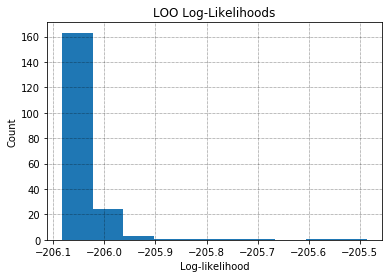

In [24]:
fig_ll=plt.figure()
plt.hist(ll_loo)
plt.ylabel('Count')
plt.xlabel('Log-likelihood')
#plt.xticks(np.linspace(-10,10,11))
plt.title('LOO Log-Likelihoods')
plt.grid()
plt.show()

# Diagnostics

We apply some diagnostics (such as those commonly used, and presented in Bastos and O'Hagan, 2009), by taking the validation points and looking at the LOO emulated values and the actual simulated values at those locations.

### Prediction Errors

In [25]:
# calculate the raw prediction error
diff=train_dat['Y_train'].ravel()-loo_mean

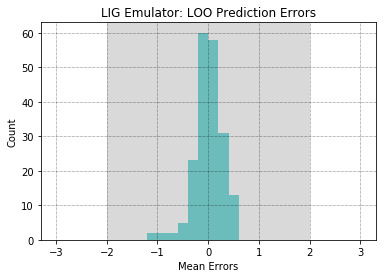

In [26]:
lig_diy_hist=plt.figure()
plt.grid()
plt.hist(diff,bins=np.linspace(-3,3,31),color='c',alpha=0.5)
plt.axvspan(-2, 2, facecolor='k', alpha=0.15)
plt.title('LIG Emulator: LOO Prediction Errors')
plt.xlabel('Mean Errors')
plt.ylabel('Count')
plt.show()

### Errors across Parameter Space

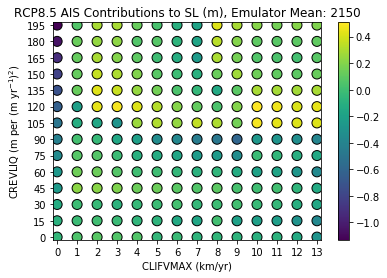

In [27]:
xv2, yv2 = np.meshgrid(train_dat['clifvmax'],train_dat['crevliq'],indexing='ij')
X_cc_plot=np.transpose([yv2,xv2]).reshape(14*14,2)
# plot the sample at 2150
error_param_fig=plt.figure()
plt.scatter(X_cc_plot[:,1],X_cc_plot[:,0],c=np.squeeze(diff),s=100,edgecolors='k')
plt.ylim([-2.5,197.5])
plt.xlim([-0.2,13.2])
plt.xticks(train_dat['clifvmax'])
plt.yticks(train_dat['crevliq'])
plt.xlabel('CLIFVMAX (km/yr)')
plt.ylabel('CREVLIQ (m per (m yr$^{−1}$)$^{2}$)')
plt.title('RCP8.5 AIS Contributions to SL (m), Emulator Mean: 2150')
plt.colorbar()
plt.show()

### Standardized Prediction Error, $D_i^I$

This error is given at every location in the training simulation dataset, and if the emulator properly represents the simulator, then the errors should have a Student-t distribution, conditional on the training data and hyperparameters.

In [28]:
# calculate the standardized prediction error
DiY=(train_dat['Y_train'].ravel()-loo_mean)/np.sqrt(loo_var)

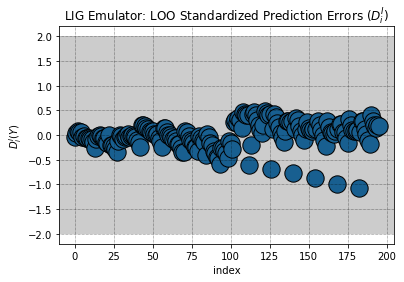

In [29]:
plt.figure()
plt.scatter(np.arange(196),DiY,s=300,edgecolors='k')
# shade the region between -2 and 2 (the 95% confidence intervals for a Student-t distribution)
plt.axhspan(-2, 2, facecolor='k', alpha=0.2)
plt.axis('tight')
plt.title('LIG Emulator: LOO Standardized Prediction Errors ($D_i^I$)')
plt.ylabel('$D_i^I(Y)$')
plt.xlabel('index')
plt.grid()
plt.show()

In [30]:
sum(np.where(np.abs(DiY)>2))

array([], dtype=int64)

### Normalized Euclidean Distance, $d$

Following the procedure of Edwards et al. (2019), for comparison, we may explore the LOO on our emulator by looking at these standardized prediction errors and their sum:

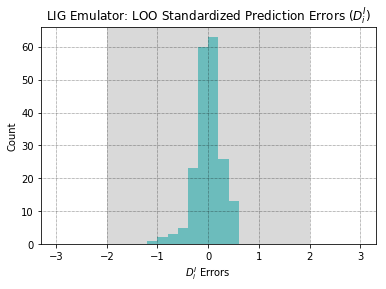

In [31]:
lig_diy_hist=plt.figure()
plt.grid()
plt.hist(DiY,bins=np.linspace(-3,3,31),color='c',alpha=0.5)
plt.axvspan(-2, 2, facecolor='k', alpha=0.15)
plt.title('LIG Emulator: LOO Standardized Prediction Errors ($D_i^I$)')
plt.xlabel('$D_i^I$ Errors')
plt.ylabel('Count')
plt.show()

In [32]:
# save the plot out
savename='FigS3.pdf'
lig_diy_hist.savefig(fig_save_path+savename)

In [33]:
d=np.sqrt(np.sum(np.power(train_dat['Y_train'].ravel()-loo_mean,2)/loo_var))
print(d)

3.61980828183


### Chi-Square Distance, $D_{\chi^2}$

This bulk metric can sometimes fail for a simulator which outputs a smooth function, because you can get similar outputs when elements are close together in the input space (e.g. the values are not independant). However, it can give us a reasonable first look idea of how well the model performs.

In [34]:
Dchi2=sum(np.power(DiY,2))
dof=len(DiY)-1
print("Chi-Square Distance")
print(Dchi2)

Chi-Square Distance
13.1030119972


In [35]:
# import the Chi-squared test in Python
import scipy.stats as stats
# calculate and print the critical value
crit = stats.chi2.ppf(q = 0.95, # Find the critical value for 95% confidence*
                      df = dof)   # Df = number of variable categories - 1
print("Critical value")
print(crit)

# blank space
print(' ')

# calculate and print the test's P-value
p_value = 1 - stats.chi2.cdf(x=Dchi2,  # Find the p-value
                             df=dof)
print("P value")
print(p_value)

Critical value
228.579938018
 
P value
1.0


Our Chi-Square distance is much smaller than the critical value, and we therefore cannot reject the null hypothesis here (that the data fits the model).